# Finite Element Surrogate Modelling

# 0. Imports and Setup

In [ ]:
!pip install -r  requirements.txt --quiet

In [ ]:
import re
import os
from pathlib import Path
import csv

import numpy as np
import pandas as pd
import torch

import requests
from pprint import pprint

from bisect import bisect_right

from typing import Tuple, Dict, Union

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

import uncertainty_engine as engine

from dotenv import load_dotenv

In [2]:
# automatically load .env in current directory
load_dotenv()

True

We can now tell the Uncertainty Engine who we are and which project we want to work in. For now, we will assume your personal project, but you can add a new project using the GUI: https://uncertaintyengine.ai/

In [3]:
client = engine.Client()
client.authenticate()
PROJECT_NAME = "Personal"

You can test your Engine access by viewing your projects. Occasionally (typically installing python on mac os directly from python), an access error will be raised. Run the cell titled mac os error catch to circumvent this.

In [6]:
try:
    client.projects.list_projects()
except Exception as e:
    # mac os error catch
    import os, certifi
    os.environ["SSL_CERT_FILE"] = certifi.where()

    client.projects.list_projects()

# 1. Data Preparation

In [ ]:
BOX_SHAPE = (31, 20, 8)
n_retained_dimensions = 6
lag_time = 1.0  # seconds

In [11]:
models_directory = 'models'
data_directory = 'data'
raw_data_directory = f'{data_directory}{os.sep}IN_OUT'
input_filename = 'collated_inputs'
output_filename = 'collated_outputs'
pca_filename = 'pca_matrix'

In [ ]:
def read_auto_csv(filepath, is_overwrite=False):
    with open(filepath, 'r', newline='', encoding='utf-8') as f:
        sample = f.read(2048)  # small chunk to analyse

    # Detect the delimiter
    dialect = csv.Sniffer().sniff(sample, delimiters=[',',';','\t'])
    delimiter = dialect.delimiter
    df = pd.read_csv(filepath, delimiter=delimiter)
    if delimiter != ',' and is_overwrite:
        print(f"saving: {filepath}")
        df.to_csv(filepath, index=False)
    return df

In [ ]:
is_clean = True
if is_clean:
    # Folder path
    folder = Path(raw_data_directory)
    # Iterate through matching files
    for file in folder.glob('*.csv'):
        read_auto_csv(file, is_overwrite=True)

In [ ]:
def load_numeric_csv(filepath):
    df = pd.read_csv(filepath)
    print(f"Processing: {filepath}")
    print(f"\t shape: {df.shape}")
    df.columns = df.columns.str.strip()

    df_numeric = df.apply(pd.to_numeric, errors="coerce")
    non_numeric_cols = df.columns[(df_numeric.isna() & df.notna()).any()]
    if len(non_numeric_cols) > 0:
        print(f"Non-numeric column(s) found, dropping:", list(non_numeric_cols))
        df = df.drop(columns=list(non_numeric_cols))

    return df


def make_input_features_from_file(
    filepath,
    time_col: str = "Time",
    input_cols=(
        "Convection_FilmCoef",
        "Heat Flux_Magnitude",
        "Convection_AmbientTemp",
    ),
):
    """
    Load input features from a CSV and return:
        [Time, input_cols..., source_file]

    No rolling time windows, just the original values.
    """
    df = load_numeric_csv(filepath)

    # Check required columns
    required = list(input_cols) + [time_col]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {filepath}: {missing}")

    # Keep only Time + input columns (in a controlled order)
    feats = df[[time_col, *input_cols]].copy()

    # Optional: drop first row to match previous convention
    # (e.g. if outputs lose the first row due to diffs/lag)
    feats = feats.iloc[1:].copy()

    # Keep track of source file
    feats["source_file"] = Path(filepath).name

    # Reset index to simple 0..N-1
    return feats.reset_index(drop=True)


def make_output_features_from_file(
    filepath,
    time_col="Time",
    temp_cols=None,
):
    """
    Return raw temperature fields (no derivatives).

    Each row = one time step for this simulation.
    Columns = all temperature vertices + Time + source_file.
    """
    df = load_numeric_csv(filepath)

    if time_col not in df.columns:
        raise ValueError(f"{time_col} column is required in {filepath}")

    # Auto-detect temperature columns if not provided
    if temp_cols is None:
        temp_cols = [c for c in df.columns if c != time_col]

    # TimedeltaIndex (mainly for consistency; not strictly needed here)
    t = pd.to_timedelta(df[time_col].values, unit="s")
    df_time = df.set_index(t)

    out = df_time[temp_cols].copy()

    # Add aligned time and source
    out[time_col] = df_time[time_col].values
    out["source_file"] = Path(filepath).name

    return out.reset_index(drop=True)


In [ ]:
def extract_number(path: Path):
    """
    Extract the digits between '_' and '_' for ordering.
    Example: 'abc_123_xyz.csv' → 123

    Returns float('inf') if no match is found.
    """
    match = re.search(r"_(\d+)_", path.name)
    if match:
        return int(match.group(1))
    return float("inf")


_SCENARIO_RE = re.compile(r"Scenario_(\d+)", re.IGNORECASE)

def _scenario_id_from_name(pathlike) -> int | None:
    """Extract X from filenames like Scenario_X_exc.csv / Scenario_X_out.csv."""
    m = _SCENARIO_RE.search(Path(pathlike).name)
    return int(m.group(1)) if m else None


def collate_paired_datasets(
    foldername,
    input_pattern="*_exc.csv",
    output_pattern="*out.csv",
    time_col="Time",
    input_cols=(
        "Convection_FilmCoef",
        "Heat Flux_Magnitude",
        "Convection_AmbientTemp",
    ),
    temp_cols=None,
    include_scenarios=None,
):
    folder = Path(foldername)

    # Gather files
    input_files_all = list(folder.glob(input_pattern))
    output_files_all = list(folder.glob(output_pattern))

    # Build {scenario_id: filepath} maps (one-to-one expectation)
    in_map = {}
    out_map = {}

    for f in input_files_all:
        sid = _scenario_id_from_name(f)
        if sid is None:
            continue
        if sid in in_map:
            raise ValueError(f"Multiple input files found for Scenario_{sid}: {in_map[sid].name}, {f.name}")
        in_map[sid] = f

    for f in output_files_all:
        sid = _scenario_id_from_name(f)
        if sid is None:
            continue
        if sid in out_map:
            raise ValueError(f"Multiple output files found for Scenario_{sid}: {out_map[sid].name}, {f.name}")
        out_map[sid] = f

    # Decide which scenarios to include
    if include_scenarios is None:
        scenario_ids = sorted(set(in_map.keys()) & set(out_map.keys()))
    else:
        scenario_ids = sorted(set(int(s) for s in include_scenarios))

    # Check coverage / mismatches
    missing_in = [sid for sid in scenario_ids if sid not in in_map]
    missing_out = [sid for sid in scenario_ids if sid not in out_map]
    if missing_in or missing_out:
        msg = []
        if missing_in:
            msg.append(f"missing input files for scenarios: {missing_in}")
        if missing_out:
            msg.append(f"missing output files for scenarios: {missing_out}")
        raise ValueError("Cannot form pairs for requested scenarios; " + "; ".join(msg))

    # Create ordered, paired lists
    input_files = [in_map[sid] for sid in scenario_ids]
    output_files = [out_map[sid] for sid in scenario_ids]

    print(f"Including scenarios: {scenario_ids}")

    all_inputs = []
    all_outputs = []

    for sid, in_file, out_file in zip(scenario_ids, input_files, output_files):
        print(f"\n=== Pair (Scenario_{sid}) ===\nInput:  {in_file.name}\nOutput: {out_file.name}")

        X_i = make_input_features_from_file(
            in_file,
            time_col=time_col,
            input_cols=input_cols,
        )
        y_i = make_output_features_from_file(
            out_file,
            time_col=time_col,
            temp_cols=temp_cols,
        )

        # Check length alignment; if mismatch, truncate to the shorter of the two
        if len(X_i) != len(y_i):
            print(
                f"WARNING: length mismatch for Scenario_{sid} "
                f"{in_file.name} / {out_file.name}: "
                f"{len(X_i)} (inputs) vs {len(y_i)} (outputs)"
            )
            n = min(len(X_i), len(y_i))
            X_i = X_i.iloc[:n].copy()
            y_i = y_i.iloc[:n].copy()

        all_inputs.append(X_i)
        all_outputs.append(y_i)

    if not all_inputs or not all_outputs:
        raise ValueError("No paired datasets were found to collate (check patterns and/or include_scenarios).")

    collated_inputs = pd.concat(all_inputs, ignore_index=True)
    collated_outputs = pd.concat(all_outputs, ignore_index=True)

    print("\nFinal collated shapes:")
    print(f"  Inputs:  {collated_inputs.shape}")
    print(f"  Outputs: {collated_outputs.shape}")

    # Show which subdatasets contribute (unique source files)
    if "source_file" in collated_inputs.columns:
        print("\nInput source files contributing:")
        print(collated_inputs["source_file"].value_counts())
    if "source_file" in collated_outputs.columns:
        print("\nOutput source files contributing:")
        print(collated_outputs["source_file"].value_counts())

    return collated_inputs, collated_outputs



In [ ]:

def build_latent_training_set(
    collated_inputs: pd.DataFrame,
    collated_outputs: pd.DataFrame,
    time_col: str = "Time",
    n_latent: int = 6,
    lag_s: float = 0.1,
):
    """
    Build (X, y) for the GP:

      X = [external inputs at time t, latent block state at t - lag_s]
      y = latent block state at time t

    where the latent block state is a low-rank linear projection of the
    4960-vertex temperature field down to n_latent dimensions.

    IMPORTANT:
    ----------
    This uses TruncatedSVD.
    It's effectively an SVD-based latent basis on the
    raw temperature fields.
    """

    # 1) Identify temperature columns (4960 vertices)
    temp_cols = [
        c for c in collated_outputs.columns
        if c not in (time_col, "source_file")
    ]

    # 2) SVD-like decomposition on the full temperature space (no centering)
    T_full = collated_outputs[temp_cols].values  # shape: (N, 4960)

    # TruncatedSVD behaves like PCA without centering
    pca = TruncatedSVD(n_components=n_latent, random_state=0)
    Z = pca.fit_transform(T_full)   # shape: (N, n_latent)

    latent_cols = [f"T_latent_{k}" for k in range(n_latent)]
    Z_df = pd.DataFrame(Z, columns=latent_cols)

    # 3) Build base table with:
    #    - external inputs (without Time/source_file)
    #    - Time + source_file (once, from outputs)
    #    - latent coordinates
    input_meta_drop = [c for c in (time_col, "source_file") if c in collated_inputs.columns]
    inputs_clean = collated_inputs.drop(columns=input_meta_drop, errors="ignore").reset_index(drop=True)

    meta = collated_outputs[[time_col, "source_file"]].reset_index(drop=True)

    base = pd.concat(
        [
            inputs_clean,
            meta,
            Z_df,
        ],
        axis=1,
    )

    # 4) For each simulation (source_file), create lagged latent features
    def add_lag_per_file(g: pd.DataFrame) -> pd.DataFrame:
        g = g.sort_values(time_col).reset_index(drop=True)

        # Estimate a representative dt for this run
        dt = g[time_col].diff().median()  # seconds
        if dt <= 0 or pd.isna(dt):
            raise ValueError(
                f"Non-positive or NaN dt detected in group {g['source_file'].iloc[0]}"
            )

        lag_steps = int(round(lag_s / dt))
        if lag_steps < 1:
            lag_steps = 1  # at least one step

        # Create lagged latent cols
        for col in latent_cols:
            g[f"{col}_lag"] = g[col].shift(lag_steps)

        return g

    base = base.groupby("source_file", group_keys=False).apply(add_lag_per_file)

    # 5) Drop rows without a full lag history (start of each simulation)
    lag_cols = [f"{c}_lag" for c in latent_cols]
    base = base.dropna(subset=lag_cols).reset_index(drop=True)

    # 6) Build X and y arrays
    external_input_cols = [
        c for c in inputs_clean.columns
        if c not in (time_col, "source_file")
    ]

    X_cols = external_input_cols + lag_cols
    y_cols = latent_cols

    X = base[X_cols].to_numpy()
    y = base[y_cols].to_numpy()

    print("Final training arrays:")
    print("  X shape:", X.shape, "(external + latent_lag)")
    print("  y shape:", y.shape, "(current latent)")

    return X, y, pca, temp_cols, X_cols, y_cols




In [ ]:
train_indices = np.hstack(([3], np.arange(5, 18), np.arange(26, 40)))
validate_indices = np.arange(18, 26)

In [ ]:
collated_train_inputs, collated_train_outputs = collate_paired_datasets(
    foldername=raw_data_directory,
    input_pattern="*_exc.csv",
    output_pattern="*out.csv",
    time_col="Time",
    input_cols=(
        "Convection_FilmCoef",
        "Heat Flux_Magnitude",
        "Convection_AmbientTemp",
    ),
    include_scenarios=train_indices,
)

collated_validate_inputs, collated_validate_outputs = collate_paired_datasets(
    foldername=raw_data_directory,
    input_pattern="*_exc.csv",
    output_pattern="*out.csv",
    time_col="Time",
    input_cols=(
        "Convection_FilmCoef",
        "Heat Flux_Magnitude",
        "Convection_AmbientTemp",
    ),
    include_scenarios=validate_indices,
)

In [ ]:
X, y, pca, temp_cols, X_cols, y_cols = build_latent_training_set(
    collated_train_inputs,
    collated_train_outputs,
    time_col="Time",
    n_latent=n_retained_dimensions,
    lag_s=lag_time,
)
pca_matrix = pca.components_[:n_retained_dimensions]

collated_inputs = pd.DataFrame(X, columns=X_cols)
collated_outputs = pd.DataFrame(y, columns=y_cols)

In [ ]:
n_thin = 1000
idx = collated_inputs.sample(n=n_thin, random_state=42).index
collated_inputs = collated_inputs.loc[idx]
collated_outputs = collated_outputs.loc[idx]

In [ ]:
collated_inputs.to_csv(f"{data_directory}{os.sep}{input_filename}.csv", index=False)
collated_outputs.to_csv(f"{data_directory}{os.sep}{output_filename}.csv", index=False)
pd.DataFrame(pca_matrix).to_csv(f"{data_directory}{os.sep}{pca_filename}.csv", index=False)

In [13]:
collated_inputs = pd.read_csv(f"{data_directory}{os.sep}{input_filename}.csv")
collated_outputs = pd.read_csv(f"{data_directory}{os.sep}{output_filename}.csv")
pca_matrix = pd.read_csv(f"{data_directory}{os.sep}{pca_filename}.csv")

In [15]:
# Upload the resources
client.resources.upload(
    project_id=client.projects.get_project_id_by_name(PROJECT_NAME),
    name=input_filename,
    resource_type="dataset",
    file_path=f"{data_directory}{os.sep}{input_filename}.csv",
)
client.resources.upload(
    project_id=client.projects.get_project_id_by_name(PROJECT_NAME),
    name=output_filename,
    resource_type="dataset",
    file_path=f"{data_directory}{os.sep}{output_filename}.csv",
)


'695e693c76e00c67b08411b0'

# 2. Training The Models

In [17]:
from uncertainty_engine.nodes.base import Node
from uncertainty_engine.nodes.resource_management import LoadDataset
from uncertainty_engine.graph import Graph
from uncertainty_engine.nodes.workflow import Workflow

def get_presigned_url(url):
    """
    Get the contents from the presigned url.
    """
    url = url.replace("https://", "http://")
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors
    return response

def train_export_torchscript_workflow(
                    client,
                   project_name: str,
                   input_dataset_name: str,
                   output_dataset_name: str,
                    output_column_name: str,
                   save_model_name: str,
                   is_visualise_workflow: bool = False,
                   is_print_full_output: bool = False) -> dict:
    """
    A workflow that trains a machine learning model.
    Here, we assume all resources have already been uploaded to the cloud.
    :param client: The Uncertainty Engine client.
    :param project_name: The name of the project.
    :param dataset_name: The name of the dataset.
    :param input_names: The names of the input columns.
    :param output_names: The names of the output columns.
    :param save_model_name: The name to save the trained model as.
    :param is_visualise_workflow: Whether to print the workflow graph.
    :param is_print_full_output: Whether to print the full output of the workflow.
    :return: The response from running the workflow.
    """
    # 1. Create the graph
    graph = Graph()

    # 2. Create relevant nodes, handles, and add to graph:

    # 2.a. Load input dataset node
    load_input_data = LoadDataset(
        label="Load Input Dataset",
        file_id=client.resources.get_resource_id_by_name(
            name=input_dataset_name,
            project_id=client.projects.get_project_id_by_name(PROJECT_NAME),
            resource_type='dataset'
        ),
        project_id=client.projects.get_project_id_by_name(PROJECT_NAME),
        client=client,
    )
    graph.add_node(load_input_data)  # add to graph
    input_dataset = load_input_data.make_handle("file")  # add handle

    # 2.b. Load output dataset node
    load_output_data = LoadDataset(
        label="Load Output Dataset",
        file_id=client.resources.get_resource_id_by_name(
            name=output_dataset_name,
            project_id=client.projects.get_project_id_by_name(PROJECT_NAME),
            resource_type='dataset'
        ),
        project_id=client.projects.get_project_id_by_name(PROJECT_NAME),
        client=client,
    )
    graph.add_node(load_output_data)  # add to graph
    output_dataset = load_output_data.make_handle("file")  # add handle

    # 2.c. Filter dataset node for outputs
    output_dataset_column = Node(
        node_name="FilterDataset",
        label="Output Dataset",
        columns=[output_column_name],
        dataset=output_dataset,
        client=client,
    )
    graph.add_node(output_dataset_column)  # add to graph
    output_dataset_columns = output_dataset_column.make_handle("dataset")  # add handle

    # 2.d. Model config node
    model_config = Node(
        node_name="ModelConfig",
        label="Model Config",
        client=client,
    )
    graph.add_node(model_config)  # add to graph
    output_config = model_config.make_handle("config")  # add handle

    # 2.e. Train model node
    train_model = Node(
        node_name="TrainModel",
        label="Train Model",
        config=output_config,
        inputs=input_dataset,
        outputs=output_dataset_columns,
        client=client,
    )
    graph.add_node(train_model)  # add to graph
    output_model = train_model.make_handle("model")  # add handle

    # 2.f. Save model node
    save = Node(
        node_name="Save",
        label="Save",
        data=output_model,
        file_id=save_model_name,
        project_id=client.projects.get_project_id_by_name(PROJECT_NAME),
        client=client,
    )
    graph.add_node(save)  # add to graph

    # 2.g. Export torchscript node
    export = Node(
        node_name="ExportTorchScript",
        label="ExportTorchScript",
        model=output_model,
        validation_inputs=input_dataset,
        client=client,
    )
    graph.add_node(export)  # add to graph
    export_model = export.make_handle("torch_script")  # add handle

    # 2.h. Download node
    download = Node(
        node_name="Download",
        label="Download",
        file=export_model,
        name=save_model_name,
        client=client,
    )
    graph.add_node(download)  # add to graph
    if is_visualise_workflow:
        pprint(graph.nodes)

    workflow = Workflow(
        graph=graph.nodes,
        inputs=graph.external_input,
        external_input_id=graph.external_input_id,
        requested_output={
            "Torchscript": download.make_handle("file").model_dump(),
          # "Torchscript": download,
        },
        client=client
        )
    try:
        client.workflows.save(
          project_id=client.projects.get_project_id_by_name(PROJECT_NAME),
          workflow=workflow,
          workflow_name="TrainModelExportTorchscriptModel",
        )
    except Exception as e:
        print(e)

    response = client.run_node(workflow)
    if is_print_full_output:
        pprint(response.model_dump())

    try:
        urllib.request.urlretrieve(response.outputs["outputs"]["Torchscript"], f"{models_directory}{os.sep}{save_model_name}.pt")
    except Exception as e:
        print(e)

    return response.outputs

In [ ]:
output_column_names = [f"T_latent_{i}" for i in range(n_retained_dimensions)]
save_model_names = output_column_names

for cn, mn in zip(output_column_names, save_model_names):
    print(f"Modelling output: {cn}")
    response = train_export_torchscript_workflow(
                        client=client,
                      project_name=PROJECT_NAME,
                      input_dataset_name="inputs",
                      output_dataset_name="outputs",
                        output_column_name=cn,
                      save_model_name=mn,
                        is_visualise_workflow=False,
                        is_print_full_output=False
    )

Modelling output: T_latent_0
Error creating workflow record: API Error: Bad Request
Details: Duplicate workflow name: A WorkflowRecord with name TrainModelExportTorchscriptModel already exists in the project.
{'inputs': {'external_input_id': '_',
            'graph': {'nodes': {'Download': {'inputs': {'file': {'node_handle': 'torch_script',
                                                                 'node_name': 'ExportTorchScript'},
                                                        'name': {'node_handle': 'Download_name',
                                                                 'node_name': '_'}},
                                             'type': 'Download'},
                                'ExportTorchScript': {'inputs': {'model': {'node_handle': 'model',
                                                                           'node_name': 'Train '
                                                                                        'Model'},
               

# 3. Model

In [ ]:
class Model:
    def __init__(
            self,
            model_path: str) -> torch.jit.ScriptModule:
        """
        Load a TorchScript model from disk.

        Parameters
        ----------
        model_path : str
            Path to the saved TorchScript model (.pt/.pth/.torch).

        Returns
        -------
        torch.jit.ScriptModule
            The loaded and ready-to-use model.
        """
        model = torch.jit.load(model_path, map_location="cpu")
        model.eval()
        self.model = model


    def __call__(
            self,
        prediction_points: np.ndarray,
        return_dict: bool = False
    ) -> Union[
        Tuple[np.ndarray, np.ndarray],
        Dict[str, np.ndarray]
    ]:
        """
        Run prediction on a TorchScript model using NumPy input.

        Converts the input NumPy array into a float32 tensor, performs inference,
        and converts the model outputs (prediction, uncertainty) back to NumPy.

        Parameters
        ----------
        model : torch.jit.ScriptModule
            A loaded TorchScript model.
            The model is assumed to return a tuple of tensors: (prediction, uncertainty)

        prediction_points : np.ndarray
            Input data with shape (N, D).
            Will be converted to a torch.float32 tensor.

        return_dict : bool, optional
            If True, returns {"prediction": ..., "uncertainty": ...}.
            If False (default), returns (prediction, uncertainty) as a tuple.

        Returns
        -------
        dict or tuple
            If return_dict=True:
                {
                    "prediction": np.ndarray,
                    "uncertainty": np.ndarray
                }
            Else:
                (prediction: np.ndarray, uncertainty: np.ndarray)
        """
        # Convert input NumPy array into a tensor
        x = torch.tensor(prediction_points, dtype=torch.float32)
        model = self.model

        model.eval()
        with torch.no_grad():
            y_pred = model(x)  # expected: (prediction_tensor, uncertainty_tensor)

        # Convert model outputs to NumPy
        prediction_np, uncertainty_np = (
            t.detach().cpu().numpy() for t in y_pred
        )

        if return_dict:
            return {
                "prediction": prediction_np,
                "uncertainty": uncertainty_np
            }

        return prediction_np, uncertainty_np


class CombinedModel:
    def __init__(self, model_filepaths):
        self.models = [Model(model_path=fp) for fp in model_filepaths]

    def __call__(self, prediction_points, return_dict=False):
        predictions = []
        uncertainties = []
        for model in self.models:
            pred, uncert = model(prediction_points, return_dict=False)
            predictions.append(pred)
            uncertainties.append(uncert)

        # Combine predictions and uncertainties (e.g., by averaging)
        combined_prediction = np.hstack(predictions)
        combined_uncertainty = np.hstack(uncertainties)

        if return_dict:
            return {
                "prediction": combined_prediction,
                "uncertainty": combined_uncertainty
            }

        return combined_prediction, combined_uncertainty


class FMU:
    """
    Functional Mock-up Unit for block temperature evolution using a GP in latent space.

    Model inputs (to GP):
        [ convective_coef, heat_flux, ambient_temp, latent_state_at_t_minus_lag ]

    Model outputs (from GP):
        latent_state_at_current_time

    The FMU:
      - Stores the full temperature field (e.g. 4960 vertices).
      - Maps full -> latent via forward_matrix.
      - Maps latent -> full via backward_matrix.
      - Maintains a history of latent states over time so it can
        interpolate the latent state at (current_time + dt - lag_s).

    Parameters
    ----------
    model : callable
        Surrogate GP model with signature:
            latent_mean, latent_uncertainty = model(prediction_points=features)
        where:
            latent_mean: shape (n_latent,) or (1, n_latent)
            latent_uncertainty: same shape (std devs, MC std, etc.)
    forward_matrix : np.ndarray
        Matrix mapping full temperature state to latent:
            z = T @ forward_matrix
        Shape: (n_vertices, n_latent)
    backward_matrix : np.ndarray
        Matrix mapping latent state back to full space:
            T_hat = z @ backward_matrix
        Shape: (n_latent, n_vertices)
    initial_input_state : np.ndarray
        Initial external inputs, shape (3,) for:
            [Convection_FilmCoef, Heat Flux_Magnitude, Convection_AmbientTemp]
    initial_temp_state : np.ndarray
        Initial full temperature field, shape (n_vertices,).
    lag_s : float, optional
        Time lag in seconds for the latent memory (default 0.1 s).
    """

    def __init__(
        self,
        model,
        pca_matrix: np.ndarray,
        initial_input_state: np.ndarray,
        initial_temp_state: np.ndarray,
        lag_s: float = lag_time,
        n_mc: int = 16,
        random_state = 42,
    ):
        self.model = model

        self.backward_matrix = np.asarray(pca_matrix, dtype=float)
        self.forward_matrix = self.backward_matrix.T

        # State: full temperature field
        self.current_temp_state = np.asarray(initial_temp_state, dtype=float).copy()
        self.current_temp_uncertainty = np.zeros_like(self.current_temp_state)

        # External inputs (3 scalars)
        self.current_input_state = np.asarray(initial_input_state, dtype=float).copy()

        # RNG for Monte Carlo
        self.n_mc = int(n_mc)
        self.rng = np.random.default_rng(random_state)

        # Time management
        self.current_time = 0.0
        self.lag_s = float(lag_s)

        # Initial latent state (from full field)
        self.current_latent_state = self.current_temp_state @ self.forward_matrix  # (n_latent,)
        self.current_latent_uncertainty = np.zeros_like(self.current_latent_state)

        # History of latent states (for interpolation)
        # times[i] corresponds to latent_history[i]
        self.times = [self.current_time]
        self.latent_history = [self.current_latent_state.copy()]
        self.latent_std_history = [self.current_latent_uncertainty.copy()]

    # ---------- Internal helpers ----------


    def _interp_vector_history(self, t_query: float, times, values) -> np.ndarray:
        """
        Generic linear interpolation of a vector-valued history.
        times: list[float]
        values: list[np.ndarray] with same shape.
        """
        # Clamp if query is outside known range
        if t_query <= times[0]:
            return values[0].copy()
        if t_query >= times[-1]:
            return values[-1].copy()

        idx = bisect_right(times, t_query) - 1
        t0, t1 = times[idx], times[idx + 1]
        v0, v1 = values[idx], values[idx + 1]

        if t1 == t0:
            return v0.copy()

        w = (t_query - t0) / (t1 - t0)
        return (1.0 - w) * v0 + w * v1

    def _latent_mean_at(self, t_query: float) -> np.ndarray:
        """Latent mean at time t_query (linear interpolation)."""
        return self._interp_vector_history(t_query, self.times, self.latent_history)

    def _latent_std_at(self, t_query: float) -> np.ndarray:
        """Latent std at time t_query (linear interpolation)."""
        return self._interp_vector_history(t_query, self.times, self.latent_std_history)

    # ---------- Main step ----------

    def __call__(self, new_input_state: np.ndarray, time_step: float):
        """
        Advance the FMU by one time step, propagating uncertainty via MC.

        Parameters
        ----------
        new_input_state : np.ndarray
            External inputs at the *new* time (shape (3,)):
                [Convection_FilmCoef, Heat Flux_Magnitude, Convection_AmbientTemp]
        time_step : float
            Time step size Δt (seconds). Can vary between calls.

        Returns
        -------
        current_temp_state : np.ndarray
            Updated full temperature state at the new time (n_vertices,).
        current_temp_uncertainty : np.ndarray
            Approximate uncertainty in full temperature state (n_vertices,).
        """
        dt = float(time_step)
        if dt <= 0.0:
            raise ValueError(f"time_step must be positive, got {dt}")

        new_input_state = np.asarray(new_input_state, dtype=float).copy()

        # Time at the end of this step
        new_time = self.current_time + dt

        # Time where we need the latent memory
        t_lag = new_time - self.lag_s

        # Latent mean & std at (new_time - lag_s), via interpolation
        latent_lag_mean = self._latent_mean_at(t_lag)
        latent_lag_std = self._latent_std_at(t_lag)

        n_latent = latent_lag_mean.shape[0]
        model_inputs = np.hstack([new_input_state, latent_lag_mean])
        latent_mean_new, _ = self.model(prediction_points=model_inputs)
        latent_mean_new = latent_mean_new.squeeze()

        # --- Monte Carlo over latent input uncertainty ---
        latent_samples = []
        latent_var_cond = []  # GP conditional variances per sample

        for _ in range(self.n_mc):
            # Sample latent state at t_lag
            eps = self.rng.standard_normal(size=n_latent)
            z_lag_sample = latent_lag_mean + latent_lag_std * eps

            # Build model input: [external inputs at new_time, latent sample at t_lag]
            model_inputs = np.hstack([new_input_state, z_lag_sample])

            # Surrogate model prediction in latent space for this sample
            # Model returns (mean, std) for latent_next
            latent_mean_s, latent_std_s = self.model(prediction_points=model_inputs)

            latent_mean_s = np.asarray(latent_mean_s, dtype=float).reshape(-1)
            latent_std_s = np.asarray(latent_std_s, dtype=float).reshape(-1)

            latent_samples.append(latent_mean_s)
            latent_var_cond.append(latent_std_s**2)

        latent_samples = np.stack(latent_samples, axis=0)      # (n_mc, n_latent)
        latent_var_cond = np.stack(latent_var_cond, axis=0)    # (n_mc, n_latent)

        # --- Combine samples: law of total variance ---
        # E[z] = mean over MC of conditional means
        # latent_mean_new = latent_samples.mean(axis=0)

        # Var[z] = E[Var(z|x)] + Var(E[z|x])
        # term1: average conditional variance
        term1 = latent_var_cond.mean(axis=0)
        # term2: variance of conditional means
        term2 = latent_samples.var(axis=0, ddof=1) if self.n_mc > 1 else np.zeros_like(term1)

        latent_var_new = term1 + term2
        latent_std_new = np.sqrt(np.maximum(latent_var_new, 0.0))

        # Update latent state & uncertainty
        self.current_latent_state = latent_mean_new
        self.current_latent_uncertainty = latent_std_new

        # Map latent -> full temperature field
        self.current_temp_state = latent_mean_new @ self.backward_matrix  # (n_vertices,)

        # Approx uncertainty propagation: latent stds through |backward_matrix|
        # (assuming independence in latent dims)
        self.current_temp_uncertainty = latent_std_new @ np.abs(self.backward_matrix)

        # Update time and inputs
        self.current_time = new_time
        self.current_input_state = new_input_state

        # Append to history for future interpolation
        self.times.append(new_time)
        self.latent_history.append(self.current_latent_state.copy())
        self.latent_std_history.append(self.current_latent_uncertainty.copy())

        return self.current_temp_state, self.current_temp_uncertainty


In [41]:
models = [f"{models_directory}{os.sep}{mn}.pt" for mn in save_model_names]
model = CombinedModel(model_filepaths=models)

In [42]:
val_number = 20

In [43]:
val_in = pd.read_csv(f"{raw_data_directory}{os.sep}Scenario_{val_number}_exc.csv")
val_out = pd.read_csv(f"{raw_data_directory}{os.sep}Scenario_{val_number}_out.csv")
val_in.columns = val_in.columns.str.strip()
val_out.columns = val_out.columns.str.strip()

In [44]:
times = val_in['Time'].to_numpy()
val_inputs = val_in[['Convection_FilmCoef', 'Heat Flux_Magnitude',	'Convection_AmbientTemp']].to_numpy()
cols = [str(x) for x in range(1, 4961)]
val_outputs = val_out[cols].to_numpy()

In [45]:
time_steps = times[1:] - times[:-1]

In [ ]:
fmu = FMU(
    model=model,
    pca_matrix=pca_matrix,
    initial_input_state=val_inputs[0],
    initial_temp_state=val_outputs[0],
    lag_s=lag_time,
)

In [64]:
output_states = []
output_state_uncertainties = []
for new, t_step in zip(val_inputs[1:], time_steps):
    new_state, new_uncertainty = fmu(new, time_step=t_step)
    output_states.append(np.array(new_state, copy=True))
    output_state_uncertainties.append(np.array(new_uncertainty, copy=True))

output_states = np.array(output_states)
output_state_uncertainties = np.array(output_state_uncertainties)
output_lower_bound = output_states - 1.96 * output_state_uncertainties
output_upper_bound = output_states + 1.96 * output_state_uncertainties

In [110]:
# reshape
times_plot = times[1:]
val_outputs_plot = val_outputs[1:]

output_error = np.abs(output_states - val_outputs_plot)

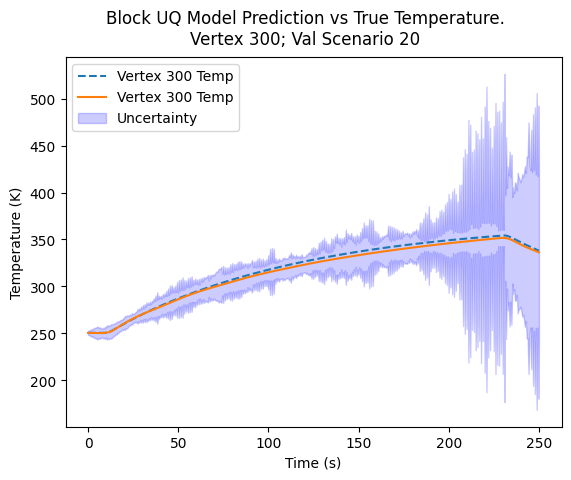

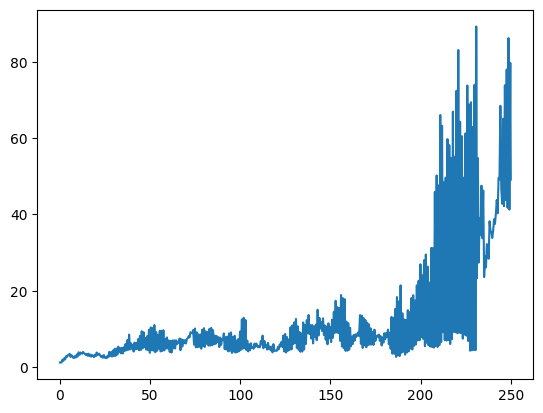

In [ ]:
plot_vertex = 300

plt.plot(times_plot, val_outputs_plot[:, plot_vertex], label=f"Vertex {plot_vertex} Temp", linestyle='dashed')
plt.plot(times_plot, output_states[:, plot_vertex], label=f"Vertex {plot_vertex} Temp")
plt.fill_between(times_plot,
                 output_lower_bound[:, plot_vertex],
                 output_upper_bound[:, plot_vertex],
                 color='blue', alpha=0.2, label="Uncertainty")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.suptitle(f"Block UQ Model Prediction vs True Temperature.\nVertex {plot_vertex}; Val Scenario {val_number}")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pyvista as pv
pv.set_jupyter_backend("trame")  # good default for notebooks

def reshape_values(values, shape=BOX_SHAPE):
    nx, ny, nz = shape
    G = values.reshape((nx, ny, nz), order="C")
    # Make an ImageData (structured grid)
    img = pv.ImageData(dimensions=(nx, ny, nz))
    img.point_data["Temperature [K]"] = G.ravel() #order="F")  # point ordering in VTK is Fortran-like
    return img

def plot_box(
        time_point,
        ground_truth,
        prediction,
        error,
        uncertainty,
        cmap="hot",
        opacity=0.8):
    
    p = pv.Plotter(shape=(2, 2))

    
    p.subplot(0, 0)
    p.add_text("Ground Truth")
    p.add_volume(reshape_values(ground_truth[time_point]), cmap=cmap, opacity=opacity, shade=True)

    p.subplot(0, 1)
    p.add_text("Prediction")
    p.add_volume(reshape_values(prediction[time_point]), cmap=cmap, opacity=opacity, shade=True)

    p.subplot(1, 0)
    p.add_text("Absolute Error")
    p.add_volume(reshape_values(error[time_point]), cmap=cmap, opacity=opacity, shade=True)

    p.subplot(1, 1)
    p.add_text("Uncertainty")
    p.add_volume(reshape_values(uncertainty[time_point]), cmap=cmap, opacity=opacity, shade=True)
    

    p.link_views()
    p.show()


# nx, ny, nz = (31, 20, 8)
# G = values.reshape((nx, ny, nz), order="C")
# # Make an ImageData (structured grid)
# img = pv.ImageData(dimensions=(nx, ny, nz))
# img.point_data["field"] = G.ravel() #order="F")  # point ordering in VTK is Fortran-like

# # Volume render (or slices)
# p = pv.Plotter()
# p.add_volume(
#     img,
#     scalars="field",
#     cmap="hot",          # good for temperature
#     opacity=0.8, 
#     clim=(values.min(), values.max()),
# )
# p.show()

In [116]:
plot_box(
        time_point=0,
        ground_truth=val_outputs_plot,
        prediction=output_states,
        error=output_error,
        uncertainty=output_state_uncertainties  )


Widget(value='<iframe src="http://localhost:50494/index.html?ui=P_0x4db165590_97&reconnect=auto" class="pyvist…

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Suppose you already have:
# times: shape (t,)
# output_states: shape (t, 4960)
shape = (62, 80)
n_time, n_pix = output_states.shape
ny, nx = shape
assert ny * nx == n_pix

# ---- Colour scales ----
vmin = min(output_states.min(), val_outputs_plot.min())
vmax = max(output_states.max(), val_outputs_plot.max())

e_vmax = max(output_error.max(), output_state_uncertainties.max())
e_vmin = -e_vmax  # symmetric for error / uncertainty

# ---- Figure and axes ----
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(8, 6),
    constrained_layout=True,
)

(ax0, ax1), (ax2, ax3) = axs

# Initial frame index
i0 = 0

# ---- Initial images ----
im_truth = ax0.imshow(
    d[i0].reshape(shape),
    cmap="bwr",
    origin="lower",
    vmin=e_vmin,
    vmax=e_vmax,
)

# ---- Titles for each panel ----
ax0.set_title("Ground truth")
ax1.set_title("Prediction")
ax2.set_title("Error (pred - truth)")
ax3.set_title("Uncertainty")

# ---- Shared x/y labels ----
for ax in axs.flat:
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.supxlabel("x pixel")
fig.supylabel("y pixel")

# ---- Shared colourbars on the right ----
# One for the top row (truth + prediction)
cbar_top = fig.colorbar(
    im_truth,
    ax=[ax0, ax1],
    location="right",
    fraction=0.046,
    pad=0.04,
)
cbar_top.set_label("Value")

# One for the bottom row (error + uncertainty)
cbar_bottom = fig.colorbar(
    im_err,
    ax=[ax2, ax3],
    location="right",
    fraction=0.046,
    pad=0.04,
)
cbar_bottom.set_label("Error, Uncertainty")

# ---- Suptitle with time ----
fig.suptitle(f"t = {times[i0]:.3f}")

# ---- Animation update function ----
def update(frame_idx):
    # Update all four fields
    im_truth.set_data(val_outputs_plot[frame_idx].reshape(shape))
    im_pred.set_data(output_states[frame_idx].reshape(shape))
    im_err.set_data(output_error[frame_idx].reshape(shape))
    im_unc.set_data(output_state_uncertainties[frame_idx].reshape(shape))

    fig.suptitle(f"t = {times[frame_idx]:.3f}")
    # Returning artists is optional when blit=False, but harmless
    return [im_truth, im_pred, im_err, im_unc]

ani = FuncAnimation(
    fig,
    update,
    frames=n_time,
    interval=50,
    blit=False,   # easier when updating suptitle
)

plt.show()

# Save as GIF (no ffmpeg needed)
ani.save(f"output_{val_number}.gif", writer="pillow", fps=20)
